# Introduction to our research

*Volatility Modeling in Option Pricing: a study on arbitrage opportunities*

Our group is embarking on a research endeavor dedicated to thoroughly *analyzing the volatility exhibited by the S&P 500 index*, with a specific focus on the **VIX index** as a pivotal metric. We aim to utilize a suite of sophisticated **econometric models**, prominently including **GARCH** (Generalized Autoregressive Conditional Heteroskedasticity), and **LSTM** (Long Short-Term Memory) models, alongside other relevant approaches.

Our primary objective is twofold: firstly, to *forecast* and *predict volatility trends* within the S&P 500 using GARCH and LSTM. Secondly, we aim to compare these predictions with the *realized volatility* and the *implied volatility* (derived from call/put options on the S&P 500, represented by the VIX index).

A crucial aspect of our analysis involves *calculating* and *comparing* the actual realized volatility within a chosen 30-day timeframe. This comparison will delineate disparities between predicted, implied, and observed volatilities in the market. Through this meticulous evaluation, we seek to determine the efficacy of GARCH and LSTM models in accurately predicting market volatilities.

Our ultimate goal is to discern *how effectively* these econometric models facilitate volatility prediction within the S&P 500 and whether discernible mispricing of volatility leads to arbitrage opportunities. This study poses an *exciting challenge*, promising an intellectually stimulating exploration of financial market dynamics and predictive modeling.


# Options' theory

## An overview

A **derivative** is a financial instrument whose value is derived from the value of an underlying asset, index, or rate. In simpler terms, it's a *contract* whose price is based on the performance of something else. **Options** are a type of derivative. They derive their value from an underlying asset, which can be a stock, bond, commodity, or another financial instrument. A **call option** gives the holder the right (but not the obligation) to buy an underlying asset at a predetermined price within a specified time frame. The value of the call option is derived from the value of the underlying asset. A **put option** gives the holder the right (but not the obligation) to sell an underlying asset at a predetermined price within a specified time frame. Again, the value of the put option is derived from the value of the underlying asset. One primary use of derivatives, including options, is for risk management. They allow investors to hedge against potential losses or to speculate on price movements without owning the actual asset. Derivative contracts, including options, have *expiration dates*. This adds a time dimension to their value, and if the conditions for exercising the option are not met by the expiration date, the option may expire worthless. Derivatives offer *flexibility* in financial strategies. Traders and investors use them for various purposes, such as speculation, hedging against price movements, and managing portfolio risk.


## Pricing options

Options are priced according to the following factors:

1. The **current market price**
2. The **predetermined price** at which the option holder can buy (for a call option) or sell (for a put option) the underlying asset.
3. The **remaining time** until the option expires.
4. The measure of how much the underlying asset's price is expected to **fluctuate**.
5. The **interest rate** used to calculate the present value of future cash flows.
6. For assets that pay dividends (e.g., stocks) or have a convenience yield (e.g., commodities), these **cash flows** affect option pricing (we won’t consider this case)

# Import libraries

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/MyDrive/Finance with Big Data/Group Project')

Mounted at /content/drive


In [ ]:
!pip install arch --quiet
!pip install yfinance --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.7/981.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statistics
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.tsaplots import plot_acf as acf
from statsmodels.graphics.tsaplots import plot_pacf as pacf
from scipy.optimize import minimize

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime

import yfinance as yf

import warnings # Avoid warnings
warnings.filterwarnings('ignore')

np.random.seed(42)  # Set seed for reproducibility

# Data preprocessing

In [ ]:
s_date = datetime.date(1980,1,1)
e_date = datetime.date(2023,10,31)
data = yf.download('^SPX', start=s_date, end=e_date, group_by='ticker')

[*********************100%%**********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-01-02,0.0,108.430000,105.290001,105.760002,105.760002,40610000
1980-01-03,0.0,106.080002,103.260002,105.220001,105.220001,50480000
1980-01-04,0.0,107.080002,105.089996,106.519997,106.519997,39130000
1980-01-07,0.0,107.800003,105.800003,106.809998,106.809998,44500000
1980-01-08,0.0,109.290001,106.290001,108.949997,108.949997,53390000


In [ ]:
data = data['Close'].reset_index()
data.head()

,Date,Close
0,1980-01-02,105.760002
1,1980-01-03,105.220001
2,1980-01-04,106.519997
3,1980-01-07,106.809998
4,1980-01-08,108.949997


In this data processing sequence, we're working with financial data, likely related to the S&P 500 index. The initial step involves converting the 'Date' column to a datetime format, ensuring proper recognition of dates for subsequent analysis. Next, we compute the daily logarithmic returns of the S&P 500 index by taking the natural logarithm of the ratio between each day's closing price and the previous day's closing price. This helps quantify the percentage change in the index's value on a daily basis. Following that, we calculate volatility by employing a **rolling window approach**. Specifically, we compute the standard deviation of the logarithmic returns within a 21-day window (approximating a month of business days) and annualize it by multiplying by the square root of 252, representing the typical number of trading days in a year. This process provides us with a **measure of volatility**, offering insights into the index's historical price fluctuations over the specified time frame, aiding in risk assessment and potentially informing future investment decisions.

In [ ]:
data['Date'] = pd.to_datetime(data['Date'])
data['SPX_ret'] = np.log(data.Close / data.Close.shift())
data['SPX_vol'] = np.sqrt(data['SPX_ret'].rolling(window=21).var()*252)

The choice of a 21-day rolling window in this data processing sequence is strategic within the realm of financial analysis. By opting for a 21-day window, the analysis aligns closely with the **approximate length of a month in terms of business days**, capturing short-term fluctuations in the market. This window size strikes a balance between *sensitivity* to recent market movements and the *need to smooth out noise* inherent in daily price data. It allows for the identification of **short-term trends** and changes in market sentiment while maintaining **statistical robustness**.







In [ ]:
data.head()

,Date,Close,SPX_ret,SPX_vol
0,1980-01-02,105.760002,NaN,NaN
1,1980-01-03,105.220001,-0.005119,NaN
2,1980-01-04,106.519997,0.012279,NaN
3,1980-01-07,106.809998,0.002719,NaN
4,1980-01-08,108.949997,0.019838,NaN


In [ ]:
def realized_vol(x):

    '''
    The function calculates the realized volatility.
    ------------------------------------------------
    Parameters:
        x: pd.Series (The time series)
    Returns:
        float (The realized volatility)
    '''

    return np.sqrt(sum(x**2)*252/(len(x)))

In [ ]:
def log_ret(x):

    '''
    The function calculates the log-return of a given time series.
    ------------------------------------------------
    Parameters:
        x: pd.Series (The time series)
    Returns:
        float (The log-return, i.e., the logarithm of the ratio between the final and initial values of the time series)
    '''

    return np.log(x.iloc[-1] / x.iloc[0])

In [ ]:
RV_m = data.resample('M', on='Date')['SPX_ret'].apply(realized_vol) # Monthly avg annualized volatility
ret_m = data.resample('M', on='Date')['Close'].apply(log_ret)

data_m = pd.concat([RV_m, ret_m], axis=1)  # Concatenate the two series
data_m.columns = ['RV_m','ret_m']
data_m.dropna(axis=0, inplace=True)  # Drop missing values

We utilize these functions to calculate monthly average annualized volatility (RV_m) and log returns (ret_m) for the S&P 500 index. It uses .resample('M', on='Date') to aggregate the data by month, applying the respective functions to the 'SPX_ret' and 'Close' columns. The resulting Series are concatenated into a DataFrame (data_m), where missing values are dropped using dropna() to ensure a clean dataset for subsequent analysis. This process ultimately creates a new DataFrame (data_m) containing the monthly average annualized volatility and log returns of the S&P 500 index, providing aggregated insights into the index's performance on a monthly basis.

In [ ]:
data_m.head()

,RV_m,ret_m
Date,,
1980-02-29,0.154705,-0.012764
1980-03-31,0.236864,-0.097098
1980-04-30,0.179985,0.039435
1980-05-31,0.134487,0.053358
1980-06-30,0.128019,0.030936


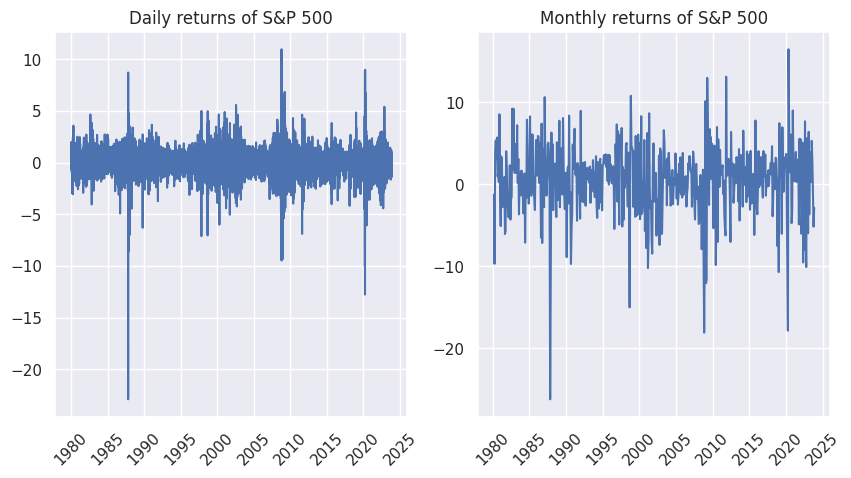

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10,5))
axes[0].plot(data['Date'],data['SPX_ret']*100)
axes[0].set_title('Daily returns of S&P 500')
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(data_m['ret_m']*100)
axes[1].set_title('Monthly returns of S&P 500')
axes[1].tick_params(axis='x', rotation=45)

plt.show()

As it is noticeable the SP500 volatility is not stable over the entire period taken into consideration. Therefore it is necessary to use a model that takes into account the **heteroskedasticity** of the time series.

Text(0.5, 0, 'Lags (Months)')

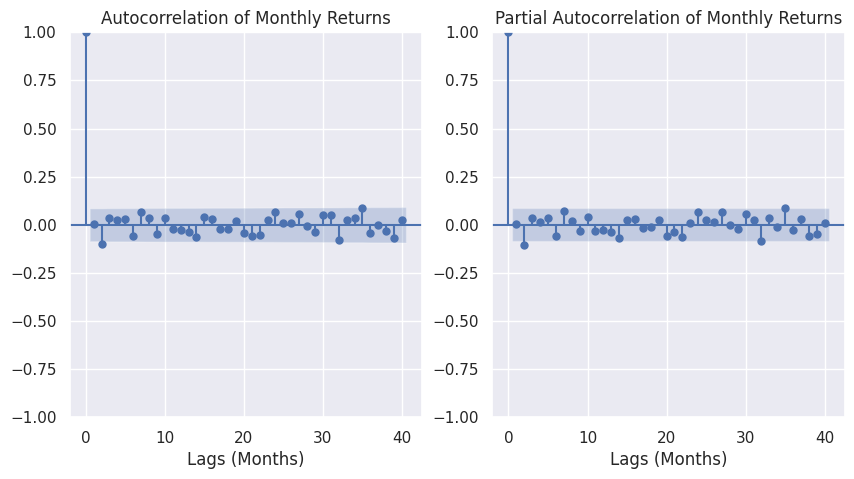

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (10,5))
acf(x = ret_m, lags = 40, ax = axes[0], title = 'Autocorrelation of Monthly Returns' )
pacf(x = ret_m, lags = 40, ax = axes[1], title = 'Partial Autocorrelation of Monthly Returns')
axes[0].set_xlabel('Lags (Months)')
axes[1].set_xlabel('Lags (Months)')

Looking at Autocorrelation and Partial Autocorrelation plots we can clearly notice that there seems not to be any type of correlation with the lags on returns, however we have seen that the variance of returns is not constant.

Text(0.5, 0, 'Lags (Months)')

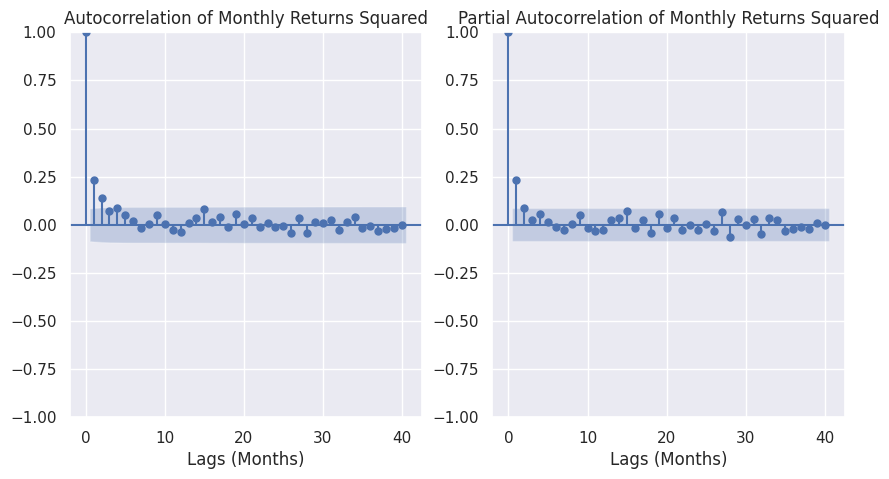

In [ ]:
fig, axes = plt.subplots(1,2 ,figsize = (10,5))
acf(x = ret_m**2, lags = 40, ax = axes[0], title = 'Autocorrelation of Monthly Returns Squared' ),
pacf(x = ret_m**2, lags = 40, ax = axes[1], title = 'Partial Autocorrelation of Monthly Returns Squared'),
axes[0].set_xlabel('Lags (Months)')
axes[1].set_xlabel('Lags (Months)')

To address the variance problem we need to look at the auto correlation and partial autocorrelation structure using squared returns in order to understand how should we set ARCH and GARCH parameters.

GARCH model formula:

\begin{equation}
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \varepsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
\end{equation}

- $\sigma_t^2$ represents the conditional variance at time $t$.
- $\omega$ is the constant term.
- $\alpha_i$ are the coefficients associated with the squared lagged innovations $ε_{t-i}^2$.
- $\varepsilon_{t-i}^2$ denotes the squared innovation at time $t-i$.
- $\beta_j$ are the coefficients associated with the lagged conditional variances $\sigma_{t-j}^2$.
- $\sigma_{t-j}^2$ represents the conditional variance at time $t-j$

Analyzing the ACF and PACF we can notice that the first lag particularly while the second is almost non-significant. These correlation structure on prices' residual are useful as hints to select the p and q parameters of the GARCH (related respectively to the ACF and PACF).

(<Figure size 1000x500 with 2 Axes>,)

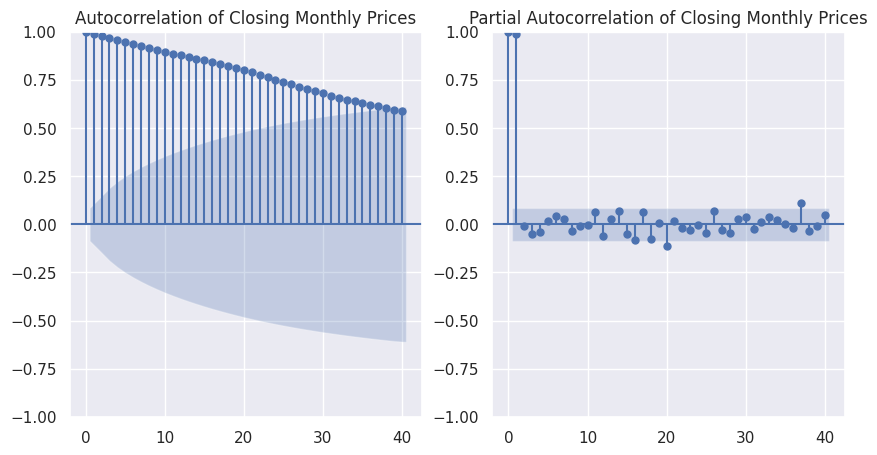

In [ ]:
closing_prices = data.resample('M', on='Date')['Close'].apply(lambda x: x.iloc[-1])
fig, axes = plt.subplots(1,2 ,figsize = (10,5))

acf(x = closing_prices, lags = 40, ax = axes[0], title = 'Autocorrelation of Closing Monthly Prices'),
pacf(x = closing_prices, lags = 40, ax = axes[1], title = 'Partial Autocorrelation of Closing Monthly Prices'),

___
# GARCH(1,1) on S&P500 returns

### Garch Utils

In [ ]:
# Splitting the dataset into train and test

def train_test(data, train_pct = 0.7):

    '''
    The function splits a given time series data into training and testing sets based on the specified training percentage.
    -----------------------------------------------------------------------------------------------------------------------
    Parameters:
        data: pd.DataFrame or pd.Series (The time series data)
        train_pct: float (The percentage of data to be used for training, default is 0.7)
    Returns:
        pd.Series, pd.Series (Training and testing sets)
    '''

    index = int(len(data) * train_pct)
    train = data.iloc[:index]
    test = data.iloc[index:]

    return train, test

In [ ]:
def garch_pq(omega, alpha, beta, rets, p=1, q=1):

    '''
    The function calculates the conditional variance of a GARCH(p, q) model.
    ------------------------------------------------------------------------
    Parameters:
        omega: float (The constant term)
        alpha: np.array (The coefficients of the lagged squared returns, length p)
        beta: np.array (The coefficients of the lagged conditional variance, length q)
        rets: np.array (The returns)
        p: int (Order of the ARCH terms)
        q: int (Order of the GARCH terms)
    Returns:
        np.array (The conditional variance)
    '''

    L = len(rets)
    sigma2 = np.zeros(L)

    for i in range(L):

        sigma2_i = omega

        # Add ARCH terms
        for j in range(1, min(p + 1, i + 1)):
            sigma2_i += alpha[j-1] * rets[i-j]**2

        # Add GARCH terms
        for k in range(1, min(q + 1, i + 1)):
            sigma2_i += beta[k-1] * sigma2[i-k]

        sigma2[i] = sigma2_i

    return sigma2

In [ ]:
def perf_measures(x, x_hat, lags, row_split, row_name):

    '''
    The function calculates the RMSE and MAE for the in-sample and out-of-sample periods.
    -------------------------------------------------------------------------------------
    Parameters:
        x: pd.Series (The time series)
        x_hat: pd.Series (The forecast)
        lags: int (The number of lags)
        row_split: int (The row number where the in-sample period ends)
        row_name: str (The name of the row)
    Returns:
        pd.DataFrame (The performance measures)
    '''

    rmse_in = np.sqrt(mse(x.iloc[lags:row_split], x_hat.iloc[lags:row_split]))
    rmse_out = np.sqrt(mse(x.iloc[row_split:], x_hat.iloc[row_split:]))

    mae_in = mae(x.iloc[lags:row_split], x_hat.iloc[lags:row_split])
    mae_out = mae(x.iloc[row_split:], x_hat.iloc[row_split:])

    data={'RMSE_in': rmse_in, 'RMSE_out': rmse_out, 'MAE_in':mae_in, 'MAE_out': mae_out}
    output = pd.DataFrame(data,index = [row_name])

    return output

### Augmented Dicky-Fuller test

In [ ]:
# Compute Augmented Dickey-Fuller test
for i in [data['Close'], data['SPX_ret'].iloc[1:], data_m['RV_m'], data_m['ret_m']]:
    result = adf(i)
    print('ADF stat: %.2f' % result[0],'p-value: %f' % result[1])

ADF stat: 1.35 p-value: 0.996885
ADF stat: -18.69 p-value: 0.000000
ADF stat: -5.77 p-value: 0.000001
ADF stat: -17.81 p-value: 0.000000


The **Augmented Dickey-Fuller** (ADF) test is commonly used to assess whether a time series has a **unit root**, which helps determine whether the series is **stationary** or **trend-stationary**. Given the results of our test we can say that:
- The closing prices are actually non stationary, in fact with a statistics of 1,35 we cannot reject the null hypothesis of the time series having a unit root.
- The situation is different with the returns, monthly annualized volatility and monthly returns in which we can reject the null hypotesis and discard the possibility of having a trend.



### Garch training

In [ ]:
train, test = train_test(data_m['ret_m'], 0.75)
garch11 = arch_model(train, vol='Garch', p=1, q=1)
garch11_fitted = garch11.fit()
omega = garch11_fitted.params['omega']
alpha = garch11_fitted.params['alpha[1]']
beta = garch11_fitted.params['beta[1]']

# Diagnostic checks
print(garch11_fitted.summary())


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4023260.0969260465
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1827.861744069311
Iteration:      3,   Func. Count:     26,   Neg. LLF: -224.3871547972185
Iteration:      4,   Func. Count:     33,   Neg. LLF: -391.4849070248687
Iteration:      5,   Func. Count:     40,   Neg. LLF: 68888994.14677493
Iteration:      6,   Func. Count:     46,   Neg. LLF: 2173620.3595476523
Iteration:      7,   Func. Count:     53,   Neg. LLF: -675.6980707157885
Iteration:      8,   Func. Count:     59,   Neg. LLF: -683.0796055855095
Iteration:      9,   Func. Count:     65,   Neg. LLF: -127.13874261703643
Iteration:     10,   Func. Count:     72,   Neg. LLF: -683.3510091852588
Iteration:     11,   Func. Count:     77,   Neg. LLF: -683.351181305346
Iteration:     12,   Func. Count:     82,   Neg. LLF: -683.3511817732214
Optimization terminated successfully    (Exit mode 0)
            Current function value: -683.3511817732214
            Itera

In [ ]:
garch22 = arch_model(train, vol='Garch', p=2, q=2)
garch22_fitted = garch22.fit()
omega22 = garch11_fitted.params['omega']
alpha22 = garch11_fitted.params['alpha[1]']
beta22 = garch11_fitted.params['beta[1]']

# Diagnostic checks
print(garch22_fitted.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 10564485.341862757
Iteration:      2,   Func. Count:     21,   Neg. LLF: 440.1344853411274
Iteration:      3,   Func. Count:     31,   Neg. LLF: 45701.68886539152
Iteration:      4,   Func. Count:     39,   Neg. LLF: -626.5318420193793
Iteration:      5,   Func. Count:     47,   Neg. LLF: -654.9006986368395
Iteration:      6,   Func. Count:     55,   Neg. LLF: -418.5115050407725
Iteration:      7,   Func. Count:     64,   Neg. LLF: -680.8787810628364
Iteration:      8,   Func. Count:     72,   Neg. LLF: -675.7660874093945
Iteration:      9,   Func. Count:     80,   Neg. LLF: -676.4645506835604
Iteration:     10,   Func. Count:     88,   Neg. LLF: -683.236383349959
Iteration:     11,   Func. Count:     96,   Neg. LLF: -669.3374337425265
Iteration:     12,   Func. Count:    104,   Neg. LLF: -683.4557452731733
Iteration:     13,   Func. Count:    112,   Neg. LLF: -683.465614397861
Iteration:     14,   Func. Count:    119,   Neg. LLF: -

In order to be sure that a GARCH(2,2) would not be better than the GARCH(1,1) we fitted it and confronted the Akaike Information Criteria (AIC).

The AIC formula is given by AIC = 2k - 2ln(L), where k is the number of estimated parameters in the model, and ln(L) is the log-likelihood of the model given the data. The term 2k penalizes models with more parameters, discouraging overfitting.
The primary goal when using AIC is to select a model that achieves a good fit to the data without unnecessary complexity, as the trade-off between goodness of fit and simplicity is critical in statistical modeling.

Lower AIC values indicate more favorable models, with the model having the lowest AIC being preferred. Therefore the first model with a slightly lower AIC (-1358.70 compared to -1354.93) is better suited for this problem.

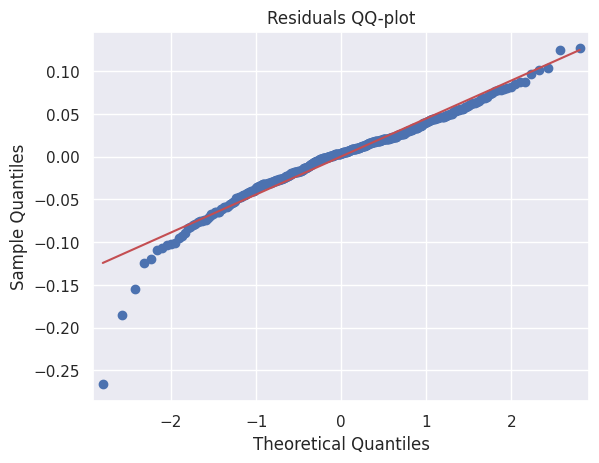

In [ ]:
# Q-Q Plot
qqplot(garch11_fitted.resid, line='s', )
plt.title('Residuals QQ-plot')
plt.show()

The QQ-plot is used to assess if the data quantiles are aligned to the ones of a target distribution. In this case it has been checked if the residuals of our GARCH were distributed as a standard normal. As it is shown in the plot above the assumpation has been met.

In [ ]:
lags = 2
valid_row = int(round(0.75 * (data_m.shape[0]-lags))) + lags

In [ ]:
data_m['GARCH11pq'] = np.sqrt(garch_pq(omega, [alpha], [beta], data_m['ret_m'], p = 1, q = 1)*12)

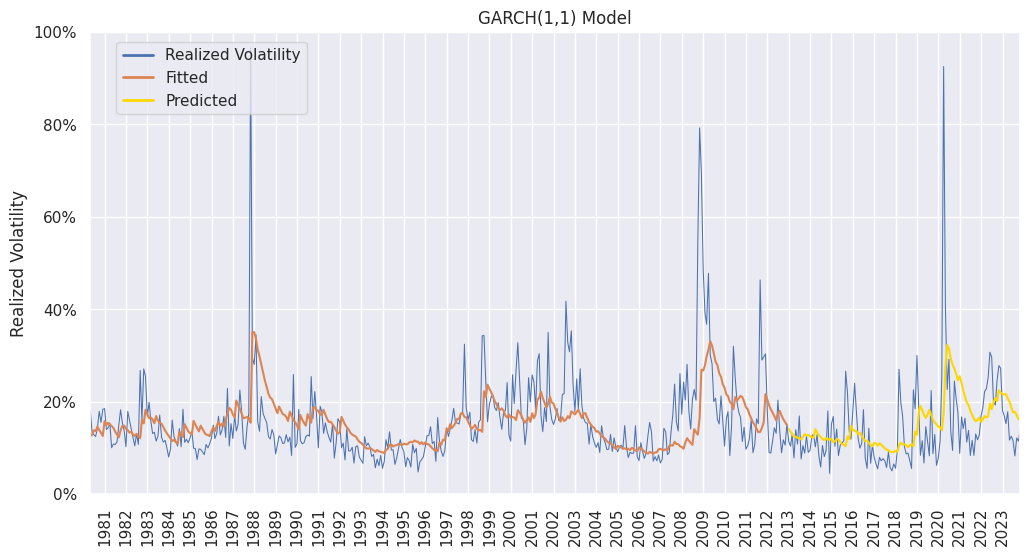

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(data_m['RV_m'].iloc[lags:], lw=0.75, label='Realized Volatility')
ax.plot(data_m['GARCH11pq'].iloc[lags:valid_row], label='Fitted')
ax.plot(data_m['GARCH11pq'].iloc[valid_row:], 'gold', label='Predicted')

# Adjustments
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.995))
for line in leg.get_lines():
    line.set_linewidth(2)
datemin = np.datetime64(data_m.index[lags], 'D')
datemax = np.datetime64(data_m.index[-1])
ax.set_xlim(datemin, datemax)
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(mtick.FixedLocator(ax.get_yticks()))
ax.set_yticklabels([f'{y*100:.0f}%' for y in ax.get_yticks()])
ax.set_ylabel('Realized Volatility')
ax.set_title('GARCH(1,1) Model')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

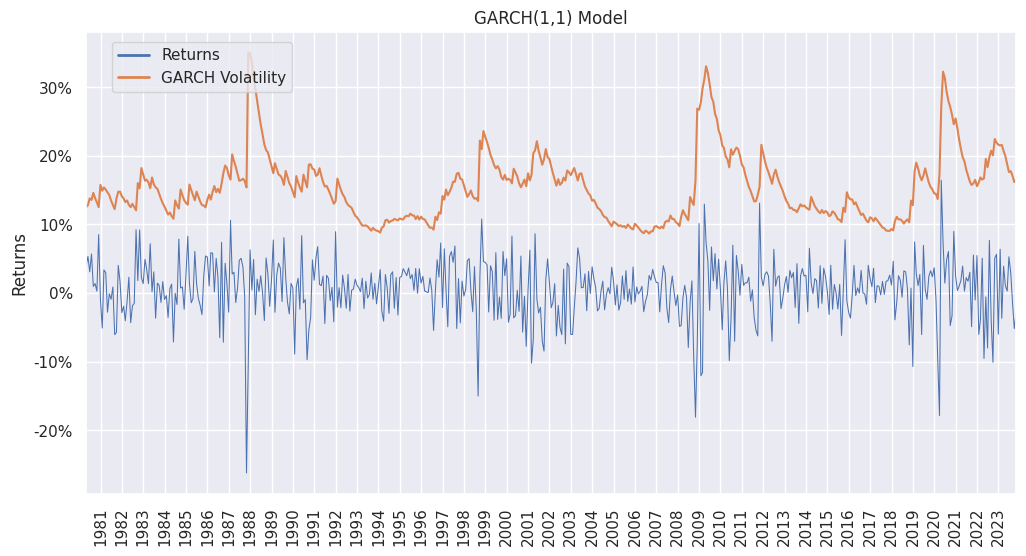

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(data_m['ret_m'].iloc[lags:], lw=0.75, label='Returns')
ax.plot(data_m['GARCH11pq'].iloc[lags:], label='GARCH Volatility')

# Adjustments
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.995))
for line in leg.get_lines():
    line.set_linewidth(2)
datemin = np.datetime64(data_m.index[lags], 'D')
datemax = np.datetime64(data_m.index[-1])
ax.set_xlim(datemin, datemax)
ax.yaxis.set_major_locator(mtick.FixedLocator(ax.get_yticks()))
ax.set_yticklabels([f'{y*100:.0f}%' for y in ax.get_yticks()])
ax.set_ylabel('Returns')
ax.set_title('GARCH(1,1) Model')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [ ]:
# Results and performances
print(f'Omega: {omega:.6f}, Alpha: {alpha:.4f}, Beta: {beta:.4f}')

V_L = np.sqrt((omega/(1-alpha-beta))*12)
print(f'Long-run volatility: {V_L:.4f}')

perf_measures(data_m['RV_m'], data_m['GARCH11pq'], 2, valid_row, 'GARCH')

Omega: 0.000051, Alpha: 0.1228, Beta: 0.8637
Long-run volatility: 0.2131


,RMSE_in,RMSE_out,MAE_in,MAE_out
GARCH,0.084945,0.091882,0.0486,0.056493


___
# LSTM MODEL


LSTM is a type of recurrent neural network (RNN) designed to process and predict sequences of data while considering long-term dependencies. It's particularly effective for time series forecasting due to its ability to retain and utilize information over extended periods.

### Key Components of LSTM:

1. **Memory Cells:**\
    LSTMs contain memory cells that store information. These cells have a unique architecture allowing them to maintain information for long durations, preventing the vanishing or exploding gradient problems that can occur in traditional RNNs.

2. **Gates:**
    - *Input Gate*:\
        The input gate determines how much of the new information should be stored in the memory cell. It's responsible for regulating the input information's impact on the cell state.\
        Comprised of a sigmoid activation function that generates values between 0 and 1, representing how much of each component of the input should be retained (0 for discard, 1 for keep entirely).\
        It multiplies the input with these weights and then updates the memory cell with this new information.
    - *Forget Gate*:\
        The forget gate decides what information to discard or forget from the current cell state. It considers the previous cell state and the current input to determine what information is no longer relevant.\
        Composed of a sigmoid activation function, it outputs values between 0 and 1, indicating how much of the previous cell state should be retained (0 for completely forget, 1 for entirely keep).
    - *Output Gate*:\
        The output gate determines what information from the cell state should be output to the next layer or used in the prediction.\
        It uses a combination of the current input and the modified cell state to decide the output.\
        Comprised of a sigmoid function to regulate the flow of information and a tanh function to scale the values between -1 and 1.

3. **Cell State:**\
    This represents the internal memory, enabling LSTMs to selectively remember or forget information over varying time intervals.

### Role of Gates and Cells:

Information Flow Regulation: Gates control the flow of information by deciding what information to let in, forget, or output\
Long-Term Dependency Handling: The cell state enables LSTMs to maintain information over extended sequences, allowing them to capture long-term dependencies crucial for time series forecasting.\
Gradient Flow Control: The gates help in preventing the vanishing or exploding gradient problem by regulating how much information flows through the network.

### Role in Predicting S&P500 Volatility:

For predicting S&P500 volatility, LSTMs can process historical stock market data sequences effectively. Here's how:

1. **Temporal Patterns:** LSTMs can capture complex temporal patterns in the historical S&P500 data, considering the influence of past market conditions on future volatility.

2. **Feature Extraction:** These networks can automatically learn relevant features from the time series data, extracting meaningful information for predicting volatility.

3. **Modeling Long-Term Dependencies:** By maintaining a memory of the past data points, LSTMs can effectively address the challenge of volatility prediction, which often relies on understanding both recent trends and past behaviors.

### Prepare the data

In [ ]:
lags = 2
features = 2

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(data_m[['RV_m','ret_m']].values)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    '''
    The function transforms a time series into a supervised learning dataset.
    A supervised learning dataset is a pd.DataFrame where the input sequence
    (t-n, ... t-1) is used to forecast the output sequence (t, t+1, ... t+n).
    -------------------------------------------------------------------------
    Parameters:
        data: pd.DataFrame or list (The time series)
        n_in: int (The number of lagged values)
        n_out: int (The number of forecasted values)
        dropnan: bool (Whether to drop rows with NaN values or not)
    Returns:
        pd.DataFrame (The supervised learning dataset)
    '''

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []

    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    if i == 0: names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else: names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan: agg.dropna(inplace=True)    # drop rows with NaN values

    return agg

In [ ]:
values = series_to_supervised(scaled, lags, 1).values
values.shape

(523, 6)

In [ ]:
def split(X, y, val=False):

    '''
    The function splits the data into train, test and validation sets.
    ----------------------------------
    Parameters:
        input time series data
        X = input data
        y = target
        val = True or False - if True the function returns 3 sets, if False 2 sets
    Returns:
        X_train, X_test, y_train, y_test (if val=False)
        X_train, X_val, X_test, y_train, y_val, y_test (if val=True)
    '''

    if val == False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        return X_train, X_test, y_train, y_test

    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
        print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)
        return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
obs = lags * features
X_train, X_val, X_test, y_train, y_val, y_test = split(values[:, :obs], values[:, -features], val=True)

(423, 4) (47, 4) (53, 4) (423,) (47,) (53,)


In [ ]:
# Reshape data for LSTM
X_train = X_train.reshape(X_train.shape[0], lags, features)
X_val = X_val.reshape(X_val.shape[0], lags, features)
X_test = X_test.reshape(X_test.shape[0], lags, features)
print(X_train.shape, X_val.shape, X_test.shape)

(423, 2, 2) (47, 2, 2) (53, 2, 2)


### Model and Fit

In [ ]:
def build_LSTM(simple=False):

    '''
    The function builds a LSTM model.
    ---------------------------------
    Parameters:
        simple: bool (Whether to build a simple LSTM model or not)
    Returns:
        model: keras.engine.sequential.Sequential (The LSTM model)
    '''

    if simple == True:
        model = Sequential(name='Simple_LSTM')
        model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')

    else:
        model = Sequential(name='LSTM')
        model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64, return_sequences=False))
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='linear'))
        adam = Adam()
        model.compile(loss='mse', optimizer=adam)

    model.summary()

    return model

In [ ]:
# Build a LSTM model
model = build_LSTM(simple=False)

# Fit model
history = model.fit(X_train, y_train, epochs=200, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stop], shuffle=False)

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 128)            67072     
                                                                 
 dropout (Dropout)           (None, 2, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116545 (455.25 KB)
Trainable params: 116545 (455.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
4/4 [=====

### In-sample and out-of-sample performance of LSTM model for the S&P500 index.

In [ ]:
def LSTM_predict(model, X, y):

    '''
    The function returns the predictions and the performance measures.
    ------------------------------------------------------------------
    Parameters:
        model: fitted model
        X : input data
        y : target
    Returns:
        pd.DataFrame (The predictions and the performance measures)
    '''

    yhat = model.predict(X)
    yhat = model.predict(X)
    X = X.reshape((X.shape[0], obs))

    # Invert scaling for forecast
    inv_yhat = np.concatenate((yhat, X[:, -1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # Invert scaling for actual
    y = y.reshape((len(y), 1))
    inv_y = np.concatenate((y, X[:, -1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    return pd.DataFrame({'RV': inv_y, 'LSTM': inv_yhat}), inv_y, inv_yhat

In [ ]:
LSTM_train, inv_y_train, inv_yhat_train = LSTM_predict(model, X_train, y_train)
LSTM_val, inv_y_val, inv_yhat_val = LSTM_predict(model, X_val, y_val)
LSTM_test, inv_y_test, inv_yhat_test = LSTM_predict(model, X_test, y_test)

2/2 [==============================] - 0s 9ms/step


In [ ]:
# Concatenate validation and test sets - excluded from training
LSTM_test = pd.concat([LSTM_val, LSTM_test])

# Concatenate all predictions
data_m['LSTM'] = np.concatenate((np.full((lags,), np.nan), inv_yhat_train, inv_yhat_val, inv_yhat_test), axis=0)

In [ ]:
# Performance metrics
rmse_in = np.sqrt(mse(LSTM_train['RV'], LSTM_train['LSTM']))
rmse_out = np.sqrt(mse(LSTM_test['RV'], LSTM_test['LSTM']))
mae_in = mae(LSTM_train['RV'], LSTM_train['LSTM'])
mae_out = mae(LSTM_test['RV'], LSTM_test['LSTM'])

metrics = pd.DataFrame({'RMSE_in': rmse_in, 'RMSE_out': rmse_out, 'MAE_in': mae_in, 'MAE_out': mae_out}, index=['LSTM'])
metrics

,RMSE_in,RMSE_out,MAE_in,MAE_out
LSTM,0.07372,0.101404,0.039784,0.056145


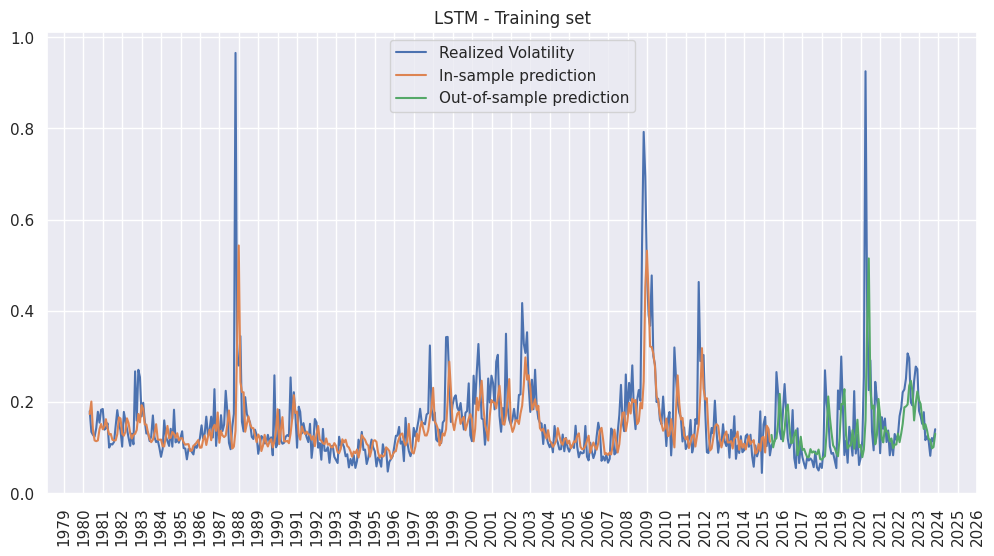

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(data_m['RV_m'].iloc[lags:], label='Realized Volatility')
ax.plot(data_m['LSTM'].iloc[lags:len(LSTM_train)],label='In-sample prediction')
ax.plot(data_m['LSTM'].iloc[len(LSTM_train):], label='Out-of-sample prediction')
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.title('LSTM - Training set')
plt.show()

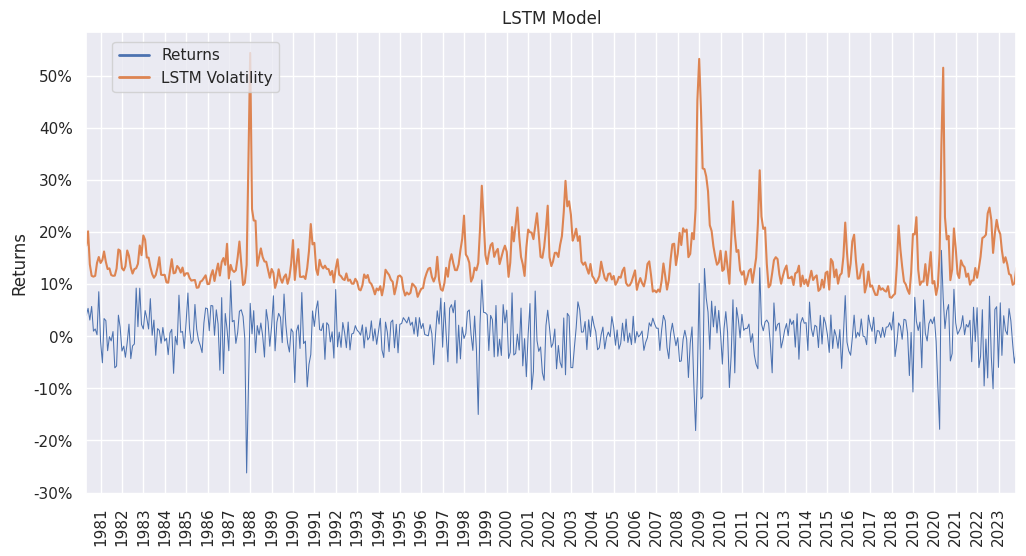

In [ ]:
# Plot
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(data_m['ret_m'].iloc[lags:], lw=0.75, label='Returns')
ax.plot(data_m['LSTM'].iloc[lags:], label='LSTM Volatility')

# Adjustments
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.995))
for line in leg.get_lines():
    line.set_linewidth(2)
datemin = np.datetime64(data_m.index[lags], 'D')
datemax = np.datetime64(data_m.index[-1])
ax.set_xlim(datemin, datemax)
ax.yaxis.set_major_locator(mtick.FixedLocator(ax.get_yticks()))
ax.set_yticklabels([f'{y*100:.0f}%' for y in ax.get_yticks()])
ax.set_ylabel('Returns')
ax.set_title('LSTM Model')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

___
# Comparison of the two models

In [ ]:
# Download VIX
vix = yf.download('^VIX', start=s_date, end=e_date, group_by='ticker').reset_index()
vix_m = vix.resample('M', on='Date')['Close'].mean()
vix_m.head()

[*********************100%%**********************]  1 of 1 completed


Date
1990-01-31    23.347273
1990-02-28    23.262632
1990-03-31    20.062273
1990-04-30    21.403500
1990-05-31    18.097727
Freq: M, Name: Close, dtype: float64

In [ ]:
plot_row = len(data_m) - valid_row

In [ ]:
vix_m

Date
1990-01-31    23.347273
1990-02-28    23.262632
1990-03-31    20.062273
1990-04-30    21.403500
1990-05-31    18.097727
                ...    
2023-06-30    13.994286
2023-07-31    13.944000
2023-08-31    15.853913
2023-09-30    15.241000
2023-10-31    18.923333
Freq: M, Name: Close, Length: 406, dtype: float64

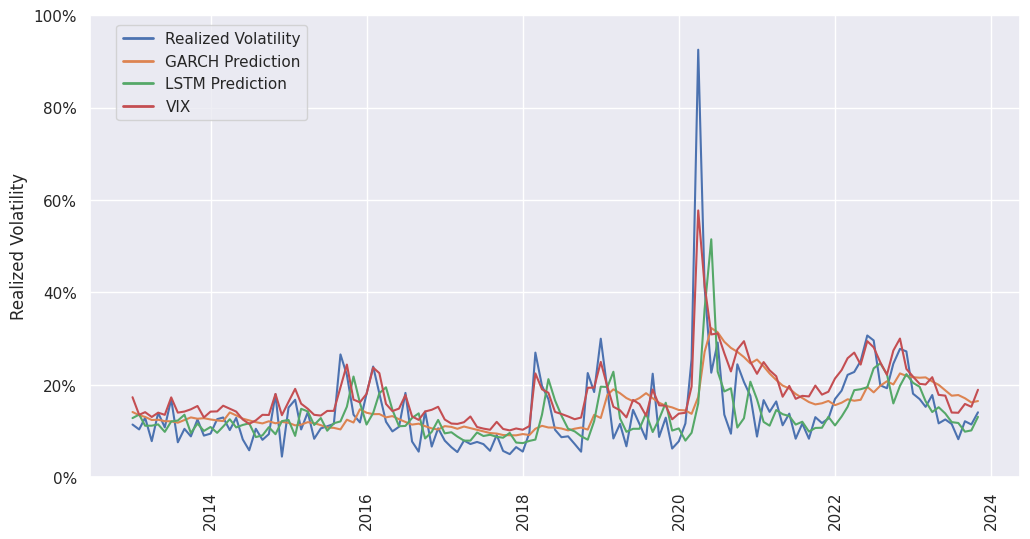

In [ ]:
# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
# ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.plot(data_m['RV_m'], label='Realized Volatility')
ax.plot(data_m['RV_m'].iloc[valid_row:], label='Realized Volatility')
ax.plot(data_m['GARCH11pq'].iloc[valid_row:], label='GARCH Prediction')
ax.plot(data_m['LSTM'].iloc[valid_row:], label='LSTM Prediction')
ax.plot(vix_m.iloc[-plot_row:]/100, label='VIX')

# Adjustments
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.995))
for line in leg.get_lines():
    line.set_linewidth(2)
datemax = np.datetime64(data_m.index[-1])
ax.set_ylim(0,1)
ax.yaxis.set_major_locator(mtick.FixedLocator(ax.get_yticks()))
ax.set_yticklabels([f'{y*100:.0f}%' for y in ax.get_yticks()])
ax.set_ylabel('Realized Volatility')
plt.xticks(rotation=90)
plt.show()

### Compute the sign score of the two models

The sign score function evaluates the accuracy of a model's predictions based on whether it correctly predicts the sign change between consecutive observations. Here's a breakdown:

**Function Purpose**:
- The function sign_accuracy aims to measure the accuracy of a model's predictions by assessing whether it correctly predicts the direction of change between consecutive observations.

**Parameters**:
- `y_test`: This parameter represents the actual values against which predictions are being evaluated.
- `y_pred`: This parameter contains the predicted values generated by the model.

**Algorithm**:
- It constructs a list `l` by iterating through the range of the length of y_test minus one `(len(y_test)-1)`. This iteration is done to compare each predicted value's sign change against the actual value's sign change in the subsequent observation.
Within this list comprehension, it checks if the sign of the difference between the predicted value at index `i+1` and the actual value at index `i` matches the sign of the difference between the actual value at index `i+1` and the actual value at index `i`. If these signs match, it appends 1 to the list `l`; otherwise, it appends 0.
Finally, it calculates the accuracy by summing up the elements of `l` (where 1 indicates correct sign prediction) and dividing this sum by the length of `y_test`.

**Returns**:
- The function returns the accuracy as a float value.

In [ ]:
def sign_accuracy(y_test, y_pred):

    '''
    The function counts how many times the model predicted the correct sign with respect to the previous observation.
    -----------------------------------------------------------------------------------------------------------------
    Parameters:
        y_test: pd.Series (The actual values)
        y_pred: pd.Series (The predicted values)
    Returns:
        float (The accuracy)
    '''

    l = [1 if np.sign(y_pred[i+1] - y_test[i]) == np.sign(y_test[i+1] - y_test[i]) else 0 for i in range(len(y_test)-1)]
    return np.sum(l)/len(y_test)

print(f"GARCH(1,1) - Sign accuracy: {sign_accuracy(data_m['RV_m'].iloc[valid_row:], data_m['GARCH11pq'].iloc[valid_row:]):.2%}")
print(f"LSTM model - Sign accuracy: {sign_accuracy(data_m['RV_m'].iloc[valid_row:], data_m['LSTM'].iloc[valid_row:]):.2%}")

GARCH(1,1) - Sign accuracy: 56.49%
LSTM model - Sign accuracy: 67.18%


The `arbitrage` function evaluates the accuracy of a model's predictions concerning volatility, specifically focusing on instances where the model predicts higher volatility compared to the VIX index when the realized volatility of the S&P500 is higher than the implied volatility. Here's a breakdown:

1. **Function Purpose**:
   - The `arbitrage` function aims to assess the accuracy of a model's predictions by examining scenarios where the model predicts higher volatility (using `y_pred`) compared to the VIX index, specifically when the realized volatility of the S&P500 (represented by `y_test`) is higher than the implied volatility.

2. **Parameters**:
   - `vix_m`: This parameter is a Pandas Series representing the VIX index.
   - `y_test`: Represents the actual values (realized volatility of the S&P500).
   - `y_pred`: Represents the predicted values of volatility.

3. **Algorithm**:
   - The function constructs a list comprehension iterating through the range of `len(y_test)-1`.
   - Within the list comprehension, it checks if both the actual volatility (`y_test[i]`) and the predicted volatility (`y_pred[i]`) are greater than the VIX index value at the corresponding index `i`.
   - For each iteration where both conditions are met, it appends `1` to the list; otherwise, it appends `0`.
   - Finally, it calculates the accuracy by summing up the elements of the list (where 1 indicates the predicted higher volatility in line with the condition) and divides this sum by the length of `y_test`.

4. **Returns**:
   - The function returns the accuracy as a float value.

In [ ]:
def arbitrage(vix_m, y_test, y_pred):

    '''
    The function counts how many times the model predicted a higher volatility with respect to the VIX when
    the realized volatility of the S&P500 is higher than the implied volatility.
    -------------------------------------------------------------------------------------------------------
    Parameters:
        vix_m: pd.Series (The VIX index)
        y_test: pd.Series (The actual values)
        y_pred: pd.Series (The predicted values)
    Returns:
        float (The accuracy)
    '''

    return np.sum([1 if (y_test[i] > vix_m[i]) and (y_pred[i] > vix_m[i]) else 0 for i in range(len(y_test)-1)])/len(y_test)

print(f"GARCH predictions accuracy against VIX: {arbitrage(vix_m.iloc[-plot_row:], data_m['RV_m'].iloc[valid_row:], data_m['GARCH11pq'].iloc[valid_row:]):.2%}")
print(f"LSTM predictions accuracy against VIX: {arbitrage(vix_m.iloc[-plot_row:], data_m['RV_m'].iloc[valid_row:], data_m['LSTM'].iloc[valid_row:]):.2%}")

GARCH predictions accuracy against VIX: 0.00%
LSTM predictions accuracy against VIX: 0.00%


In the plot above we aim at providing a fictious prediction, which is always in between the realized volatility and the VIX (implied volatility).

This means that the ideal model is able to predict the volatility better than the VIX when the latter fails (thus when the VIX is below the realized volatility).

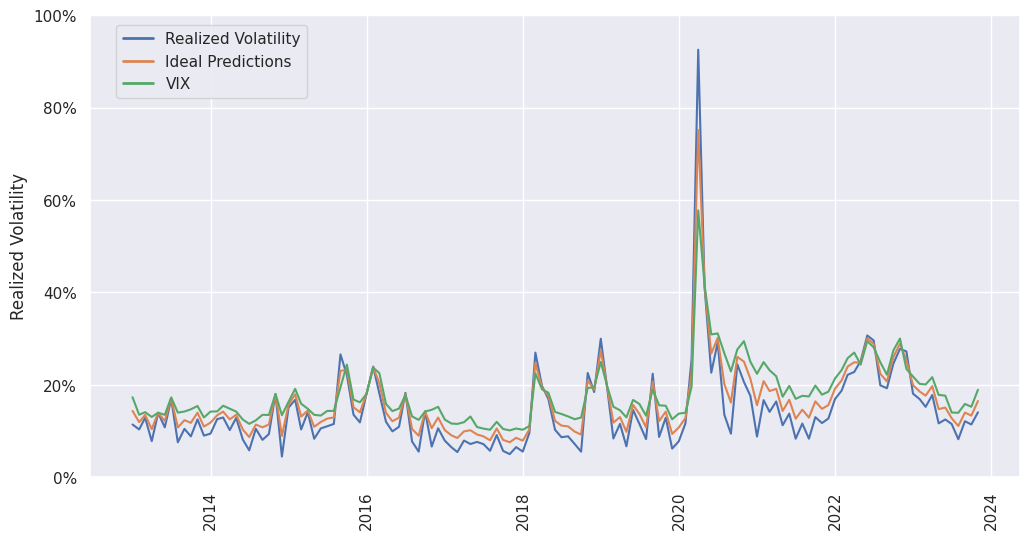

In [ ]:
# Ideal predictions

# Plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.plot(data_m['RV_m'].iloc[valid_row:], label='Realized Volatility')
ax.plot(0.5 * data_m['RV_m'].iloc[valid_row:] + 0.5 * vix_m.iloc[-plot_row:]/100, label='Ideal Predictions')
ax.plot(vix_m.iloc[-plot_row:]/100, label='VIX')

# Adjustments
leg = ax.legend(loc="upper left", bbox_to_anchor=(0.02, 0.995))
for line in leg.get_lines():
    line.set_linewidth(2)
datemax = np.datetime64(data_m.index[-1])
ax.set_ylim(0,1)
ax.yaxis.set_major_locator(mtick.FixedLocator(ax.get_yticks()))
ax.set_yticklabels([f'{y*100:.0f}%' for y in ax.get_yticks()])
ax.set_ylabel('Realized Volatility')
plt.xticks(rotation=90)
plt.show()

In conclusion, neither model outperformed the VIX, owing to the following reasons:
- The GARCH is not as flexible, so it is unaffected by short-term occurrences;
- The LSTM depends too much on past observations, so its forecasts are the same as changing the observations by one day.

As a result, the *arbitrage score* of both models is **0.00%**, and because implied volatility is usually always greater than realized volatility, our models have little opportunities to outperform the VIX.

This assignment was beneficial in terms of learning about Option Theory and gaining experience with time-series data. Obviously, our expectations for performance were slightly greater, since we have seen ML trump financial theory in some cases (for example, in FinTech), but we are really pleased with the results.

